In this tutorial, we would like to implement [VALMOD](https://arxiv.org/pdf/2008.13447.pdf) algorithm. The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and the range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [3]:
%matplotlib inline

import stumpy
from stumpy import stump, core, config
import pandas as pd
import numpy as np
import numba
from numba import njit, prange
import matplotlib.pyplot as plt
import math
import time

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

Matrix profile provides an efficient algorithm for finding the exact motif pair of a time series for a given window size. However, searching for motifs with different lengths can result in different motif pairs that might be of interest. Given a data series
`T` and a subsequence length-range `[m_min,...,m_max]`, we want to find the motif pairs of all lengths in `[m_min,...,m_max]`. One approach is to compute matrix profile for each subsequence length in `[m_min, ..., m_max]`. However, [VALMOD](https://arxiv.org/pdf/2008.13447.pdf) provides an alternative approach that should speed up this data mining task for real-world data. VALMOD takes advantage of the previously-computed distances to compute the lower bounds of distances for subsequences with longer window sizes. Then, it uses those lower bound values to find an approximate matrix profile.

## 2. The Lower Bound (LB) of Distance

Suppose the z-normalized distance between $T_{i,m}=T[i:i+m]$ and $T_{j,m}=T[j:j+m]$ was already calculated. Let $d_{i,j}^{(m)}$ denote that distance. VALMOD shows that $d_{i,j}^{(m+1)} \ge LB_{i,j,m}^{(m+1)}$, where $LB_{i,j,m}^{(m+1)}$ is calculated as follows:

$$LB_{i,j,m}^{(m+1)} = \frac{\sigma_{i,m}}{\sigma_{i,m+1}}\sqrt{m(1-r^{2})}$$ 

where: $$r=max(\rho_{i,j}^{(m)}, 0)$$ 


$\rho_{i,j,m}$ is the pearson correlation between the two subsequences $T_{i,m}=T[i:i+m]$ and $T_{j,m}=T[j:j+m]$, and has the following relationship with its corresponding distance: 

$$
\begin{align}
d^{(m)}_{j,i} ={}& 
\sqrt{
2m \left(
1-\rho^{(m)}_{j,i}
\right)
}
\\
\end{align}
$$

**Note:** We can use $\frac{\sigma_{j,m}}{\sigma_{j,m+1}}$ instead when computing $LB_{i,j,m}^{(m+1)}$, which can give a different value.

### Example

The following example computes the actual distance and its LB

In [4]:
T = np.random.rand(100)
m = 5

# Compute distance profile between the query Q and T
Q = np.random.rand(m)
D = core.mass(Q, T)

# Add one new element to the existing Q
Q_new = np.append(Q, np.random.rand())
D_new = core.mass(Q_new, T)

Let's compute the LowerBound (LB) for D_new. `D[i]` represents the distance between `Q` and `T[i:i+m]`. 
`D_new[i]` represents the distance between `Q_new` and `T[i:i+(m+1)]`. Recall that $LB = \frac{\sigma_{i,m}}{\sigma_{i,m+1}}\sqrt{m(1-r^{2})}$, where $r=max(\rho_{i,j}^{m}, 0)$. The factor $\frac{\sigma_{m}}{\sigma_{m+1}}$ can be computed based on `Q` or based on subsequence in `T`! Let's try both and check out the results.

#### Option 1
Compute LB by considering the change of standard deviation in Q:

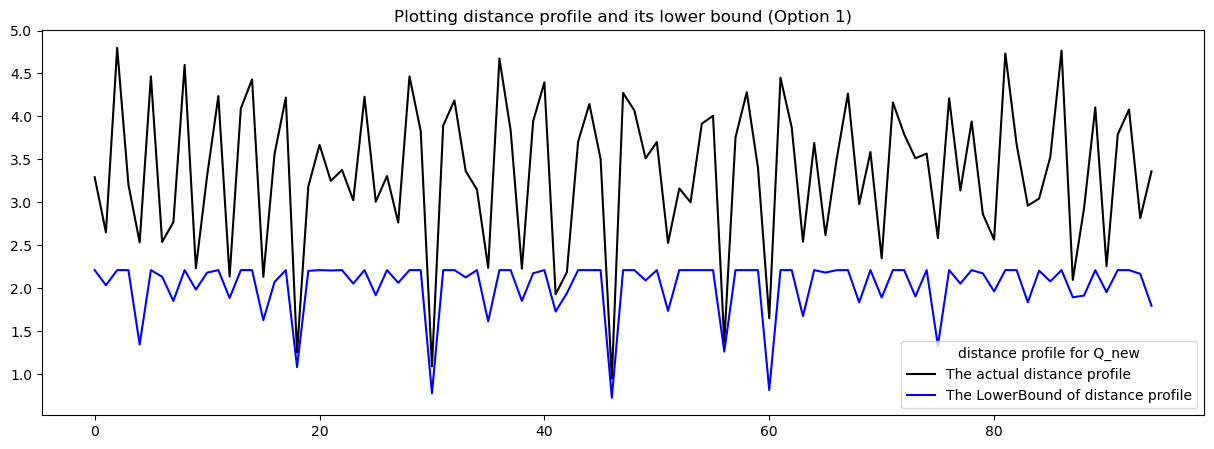

In [5]:
σ_Q = np.std(Q)
σ_Q_new = np.std(Q_new)

l_new = len(T) - len(Q_new) + 1
ρ = 1.0 - np.square(D) / (2 * m)
ρ[:l_new] = np.clip(ρ[:l_new], a_min=0, a_max=1.0)

LB_option_1 = (σ_Q / σ_Q_new) * np.sqrt(m * (1 - np.square(ρ[:l_new])))

# assertion
assert np.all(LB_option_1 <= D_new)

# plot
plt.figure(figsize=(15, 5))
plt.title('Plotting distance profile and its lower bound (Option 1)')
plt.plot(D_new, color='k', label='The actual distance profile')
plt.plot(LB_option_1, color='b', label='The LowerBound of distance profile')
plt.legend(title='distance profile for Q_new')
plt.show()

#### Option 2

Compute LB by considering the change of standard deviation in the subsequences of T:

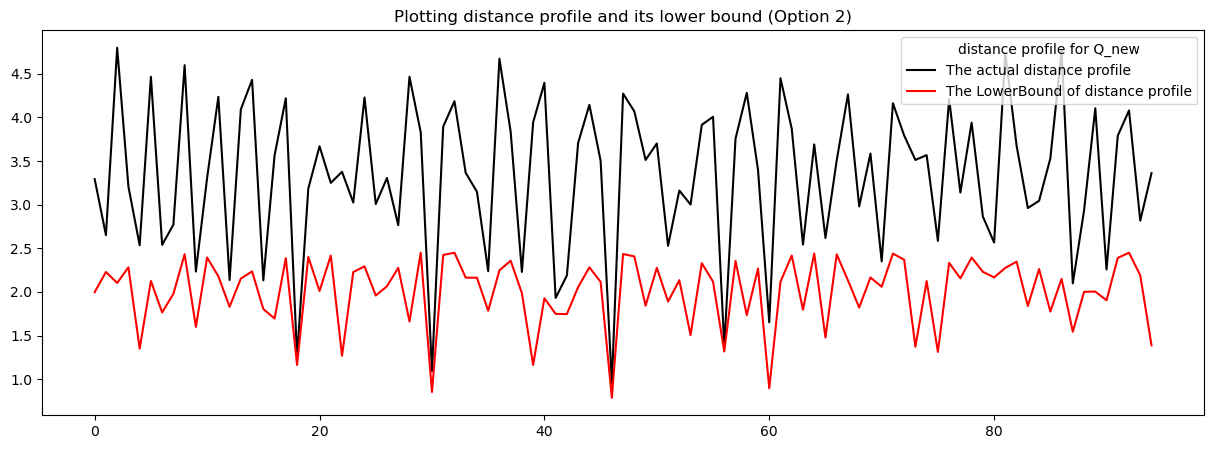

In [6]:
_, Σ_T = core.compute_mean_std(T, m)
_, Σ_T_new = core.compute_mean_std(T, len(Q_new))

l_new = len(T) - len(Q_new) + 1
ρ = 1.0 - np.square(D) / (2 * m)
ρ[:l_new] = np.clip(ρ[:l_new], a_min=0, a_max=1.0)

LB_option_2 = (Σ_T[:l_new] / Σ_T_new[:l_new]) * np.sqrt(m * (1 - np.square(ρ[:l_new])))  

# assertion
assert np.all(LB_option_2 <= D_new)

# plot
plt.figure(figsize=(15, 5))
plt.title('Plotting distance profile and its lower bound (Option 2)')
plt.plot(D_new, color='k', label='The actual distance profile')
plt.plot(LB_option_2, color='r', label='The LowerBound of distance profile')
plt.legend(title='distance profile for Q_new')
plt.show()

#### Plot both Option 1 and Option 2

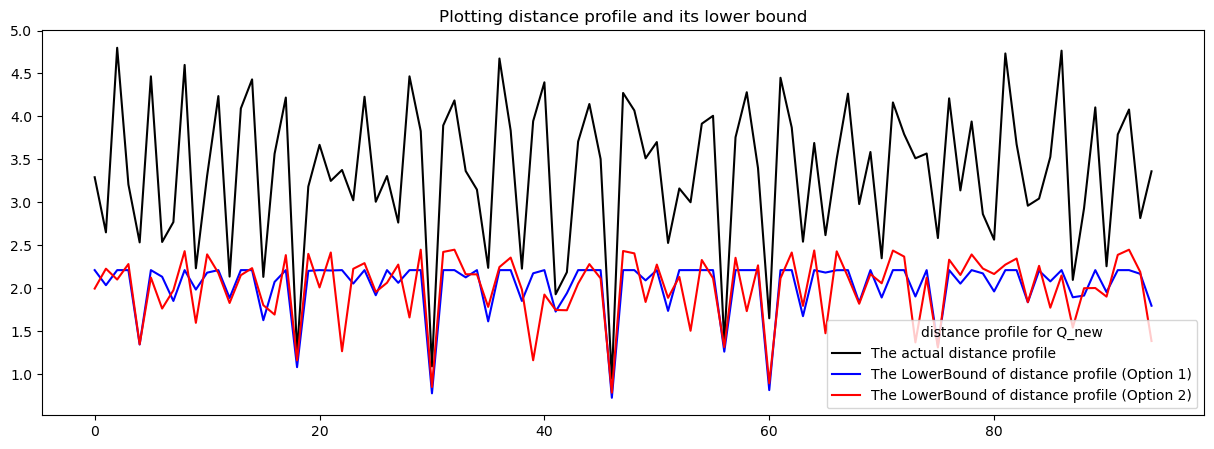

In [7]:
plt.figure(figsize=(15, 5))
plt.title('Plotting distance profile and its lower bound')
plt.plot(D_new, color='k', label='The actual distance profile')
plt.plot(LB_option_1, color='b', label='The LowerBound of distance profile (Option 1)')
plt.plot(LB_option_2, color='r', label='The LowerBound of distance profile (Option 2)')
plt.legend(title='distance profile for Q_new')
plt.show()

At some indices, `Option 1` gives a tighter LB, and at other indices `Option 2` gives a tigher LB. Recall that $LB = \frac{\sigma_{i,m}}{\sigma_{i,m+1}}\sqrt{m(1-r^{2})}$. The second part, i.e. $\sqrt{m(1-r^{2})}$, is the same in both Option 1 and Option 2. The first part, however, is different between the two options. The larger the std-based factor, the tigher the LowerBound (LB).

#### Option 3 (Best of Option 1 & 2)

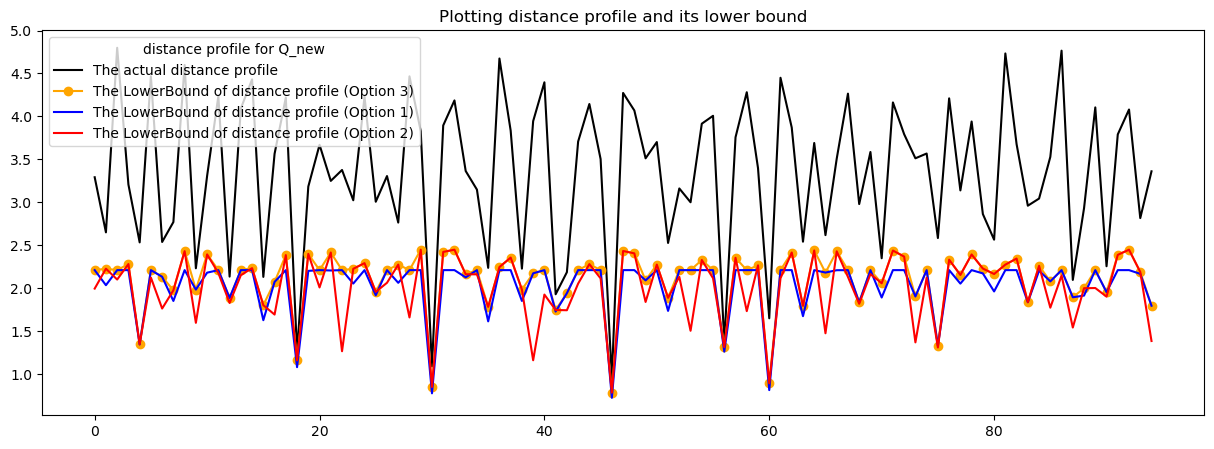

In [8]:
factor_option_1 = σ_Q / σ_Q_new
factor_option_2 = Σ_T[:l_new] / Σ_T_new[:l_new]

factor = np.maximum(factor_option_1, factor_option_2)
LB_option_3 = factor * np.sqrt(m * (1 - np.square(ρ[:l_new])))  

# assetion
assert np.all(LB_option_3 <= D_new)

# plot
plt.figure(figsize=(15, 5))
plt.title('Plotting distance profile and its lower bound')
plt.plot(D_new, color='k', label='The actual distance profile')
plt.plot(LB_option_3, color='orange', marker='o', label='The LowerBound of distance profile (Option 3)')
plt.plot(LB_option_1, color='b', label='The LowerBound of distance profile (Option 1)')
plt.plot(LB_option_2, color='r', label='The LowerBound of distance profile (Option 2)')
plt.legend(title='distance profile for Q_new')
plt.show()

## 3. Ranked Lower Bound (LB) Profile is preserved!

For the sequence `T[i:i+m]`, we can calculate its distance with all subsequences (of length `m`) in `T`. For `T[i:i+(m+1)]`, we can compute the LB of its distance to all subsequences (of length `m+1`) in `T` based on the distances computed before for length `m`. Let's consider two subsequences `T[j:j+(m+1)]` and `T[j':j'+(m+1)]`, and let's assume $LB_{i,j} \le LB_{i,j'}$, i.e.:

$$LB^{(m+1)}_{i,j,m} \leq LB^{(m+1)}_{i,j^{'},m}$$

and if we expand this:

$$\frac{
\sigma_{i,m}}
{\sigma_{i,m+1}
}
\sqrt{m(1-r_{i,j,m}^{2})} \leq \frac{
\sigma_{i,m}}
{\sigma_{i,m+1}
}
\sqrt{m(1-r_{i,j',m}^{2})}$$

As shown in previous section, we could have computed different LB by using $\frac{\sigma_{j,m}}{\sigma_{j,m+1}}$ or $\frac{\sigma_{j',m}}{\sigma_{j',m+1}}$, respectively, for the left or right terms of the above inequation. However, using the common factor $\frac{\sigma_{i,m}}{\sigma_{i,m+1}}$ allows us to preserve this rank as we increase the length of subsequences! To better see this, let's multiply both sides by the positive factor $\frac{\sigma_{i,m+1}}{\sigma_{i,m+2}}$, and that gives:


$$\frac{
\sigma_{i,m}}
{\sigma_{i,m+2}
}
\sqrt{m(1-r_{i,j}^{2})} \leq \frac{
\sigma_{i,m}}
{\sigma_{i,m+2}
}
\sqrt{m(1-r_{i,j'}^{2})}$$

which is $LB^{(m+2)}_{i,j,m} \leq LB^{(m+2)}_{i,j^{'},m}$, and those are the LB values for the distance between `T[i:i+(m+2)]` and `T[j:j+(m+2)]` (left) and the distance between `T[i:i+(m+2)]` and `T[j':j'+(m+2)]` (right). Note that the LB values for subsequences of length `m+2` are computed based on the distances computed for subsequences of length `m`!

**Note:**

(1) It was shown that the ranked LB is preserved. In fact, the order of subsequences in ranked LB for subseqence $m'$ is the same as the order of subsequences in ranked distances for subsequence $m$ (where $m < m'$). In other words: 

$$d_{i,j}^{(m)} <= d_{i,j'}^{(m)} \implies \rho_{i,j}^{(m)} >= \rho_{i,j'}^{(m)} \implies r_{i,j}^{(m)} >= r_{i,j'}^{(m)} \implies LB_{i,j,m}^{(m')}<=LB_{i,j',m}^{(m')}$$

(2) Note that: $LB_{i,j,m}^{(m')} \le LB_{i,j',m}^{(m')}$ does NOT mean $d_{i,j}^{(m')} \le d_{i,j'}^{(m')}$. Suppose we compute the LB values between subsequence $T[i:i+m']$ and all of its neighbours, and they are ranked as follows:

$LB_{i,j_{1}} \le LB_{i,j_{2}} \le LB_{i,j_{3}} \le LB_{i,j_{4}} \le .....$

We can start computing the actual distance for pair $(i, j_{1})$. If we are lucky and the actual distance is $\le LB_{i,j_{2}}$, then it means it will be less than the actual distances that will be computed for other neighbours! No need to continue futher! We already found the nearest neighbour. If not, we can try the second pair, i.e. $(i, j_{2})$, and so on. 

# 4-VALMOD algorithm
The [VALMOD paper](https://arxiv.org/pdf/2008.13447.pdf) proposes different algorithms to address different problems. Let's start with the first problem as described in the paper:

> **Problem 1 (Variable-Length Motif Pair Discovery)** Given a data series T and a subsequence length-range [m_min,...,m_max], we want to find the data series motif pairs of all lengths in [m_min,...,m_max], occurring in T.

## 4-1- Naive Approach

A naive approach is to compute exact matrix profile for each window size.

In [9]:
def naive_find_motif(T, m_values):
    m_values_sorted = np.sort(m_values)
    
    num_m = len(m_values_sorted)
    motif_distance = np.full(num_m, np.inf, dtype=np.float64)
    motif_index = np.full(num_m, -1, dtype=np.int64)
    motif_index_nn = np.full(num_m, -1, dtype=np.int64)
    
    for i, m in enumerate(m_values_sorted):
        mp = stump(T, m, k=1)
        
        idx = np.argmin(mp[:, 0])  # motif index 
        
        motif_distance[i] = mp[idx, 0]
        motif_index[i] = idx
        motif_index_nn[i] = mp[idx, 1]
        
    out = np.empty((num_m, 4), dtype=object)
    out[:, 0] = motif_distance
    out[:, 1] = motif_index
    out[:, 2] = motif_index_nn
    out[:, 3] = m_values_sorted
    
    return out

## 4-2- VALMOD Approach
[See Algorith3 on page 15](https://arxiv.org/pdf/2008.13447.pdf). This algorithm scans all pairs of subsequences of length `m`. However, instead of returning just the matrix profile and its indices, the algorithm also computes the lower bound values of `m+1`, and return `top-k` smallest lower bound values from each lower bound profiles. Here, we are going to return top-k matrix profile for length `m` as that allows us to calculate those `top-k` lower bound values later for `m+1`! Below, we've shown that top-k matrix profile (for length `m`) corresponds to top-k lower bound values for length `m + k`. In other words, we would like to show:

$$d_{i,j}^{(m)} \le d_{i,j'}^{(m)} \implies LB^{(m+k)}_{i,j,m} \le LB^{(m+k)}_{i,j',m}$$: 

$$
\begin{align}
d_{i,j}^{(m)} \le&{} d_{i,j'}^{(m)}
\\
\rho^{(m)}_{i,j} 
\geq&{}
\rho^{(m)}_{i,j'}
\\
\max(\rho^{(m)}_{i,j}, 0) 
\geq&{}
\max(\rho^{(m)}_{i,j'},0)
\\
\left(\max(\rho^{(m)}_{i,j}, 0)\right)^{2}
\geq&{}
\left(\max(\rho^{(m)}_{i,j'},0)\right)^{2}
\\
1 - \left(\max(\rho^{(m)}_{i,j}, 0)\right)^{2}
\leq&{}
1 - \left(\max(\rho^{(m)}_{i,j'},0)\right)^{2}
\\
\frac{\sigma_{i,m}}{\sigma_{i,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{i,j}, 0)\right)^{2}
\right]
}
\leq&{}
\frac{\sigma_{i,m}}{\sigma_{i,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{i,j'}, 0)\right)^{2}
\right]
}
\\
LB^{(m+k)}_{i,j,m} \leq{}& 
LB^{(m+k)}_{i,j',m}
\\
\end{align}
$$



This proves that the ranked distance profile (for subsequence length `m`) and its ranked lower bound (for subsequence length `m+k`) have the same order. The good news is that stumpy currently provides support for returning top-k (k>1) matrix profile values and their corresponding indices! Therefore, for each subsequence `T[i:i+m]`, we have its `top-k` smallest distances from its distance profile, and we can calculate their corresponding LB values for subsequence length `m+k` as follows: <br>

(1) Compute top-k $\rho$ based on the top-k distances <br>
(2) Compute $r = max(\rho, 0)$ <br>
(3) Compute $LB = \frac{\sigma_{i,m}}{\sigma_{i,m+k}}{\sqrt{m(1-r^{2})}}$

In [34]:
@njit(fastmath=True, parallel=True)
def _compute_LB(T, m, Σ_T, Σ_T_prev, M_prev, P_prev):
    """
    Compute LB top-k profile for subsequences of length `m` in `T`
    based on top-k distances discovered previously for subsequences
    with length recorded in M_prev. 

    The LB between two subsequnece Si'=T[i:i+m'] and Sj'=T[j:j+m'] can be computed based
    on the the distance between Si=T[i:i+m] and Sj=T[j:j+m], where m < m'. The formula is:
    LB = (std_of_Si / std_of_Si') * ((m * (1 - r ** 2))**0.5), where r = max(rho(Si,Sj), 0.0).

    For a given 2D array P_prev, P_prev[i] contains top-k smallest distances between T[i,i+M] 
    and its neighbours, where M==M_prev[i]. The standard deviation of `T[i:i+M]` is stored in
    Σ_T_prev[i]. Σ_T[i] represents the standard deviation of subsequence T[i:i+m]`, where m > M.

    Parameters
    ----------
    T : np.ndarray
        Time series

    m : int
        Window size

    Σ_T : np.ndarray
        A 1D array containing the sliding standard deviation of subsequences with length `m`

    Σ_T_prev : np.ndarray
        A 1D array containing the standard deviation of subsequences. Σ_T_prev[i] represents 
        the standard deviation of T[i:i+w], where w==M_prev[i]

    M_prev : np.ndarray
        A 1D array containing the length of subsequences used for obtaining top-k smallest distance
        for a subsequence.

    P_prev : np.ndarray
        A 2D array where P_prev[i] contains the top-k smallest distance between `T[i:i+w]`
        and its neighbours. Note that `w==M_prev[i]`

    Returns
    -------
    LB : np.ndarray
        A 2D array where LB[i] contains the lower bounds when subsequence length is `m`. It corresponds
        to the distances P_prev[i] previously computed for the subsequence length `M_prev[i]`
    """
    l = len(T) - m + 1
    k = P_prev.shape[1]

    LB = np.empty((l, k), dtype=np.float64)
    for i in prange(l):
        ρ_prev = 1.0 - np.square(P_prev[i]) / (2 * M_prev[i])
        ρ_prev = np.clip(ρ_prev, a_min=0.0, a_max=1.0)
        LB[i] = (Σ_T_prev[i] / Σ_T[i]) * np.sqrt(M_prev[i] * (1 - np.square(ρ_prev)))
    
    return LB

In [29]:
@njit(fastmath=True, parallel=True)
def _approx_stump(T, m, M_T, Σ_T, T_subseq_isconstant, LB, LB_I):
    """
    Compute approx matrix profile for time series T and window size m. For
    the i-th susbequence, this function only computes its distance to those 
    neighbours whose start indices are in `LB_I[i]`. In addition to P and I,
    this funciton also returns a boolean-valued 1D array is_exact, which 
    reflects whether `P[i]` is [guaranteed to be] exact or not.

    Parameters
    ----------
     T : np.ndarray
        Time series

    m : int
        Window size

    M_T : np.ndarray
        Rolling mean
        
    Σ_T : np.ndarray
        Rolling standard deviation
    
    T_subseq_isconstant : np.ndarray
        A boolean array that indicates whether a subsequence in `T` is constant
        (True)

    LB : np.ndarray
        The lower bound values. LB[i] represents top-k smallest lower bound values for the distances
        between T and the neighbours whose start indices are stored in LB_I[i]

    LB_I : np.ndarray
        A 2D array. LB_I[i] contains the start index of top-k neighbours discovered previously 
        based on a smaller window size.

    Returns
    -------
    P : np.ndarray
        A 1D approximate matrix profile

    I : np.ndarray
        A 1D matrix profile index. I[i] is the start index of the neighbour of i-th subsequence 
        and their distance is stored in P[i]

    is_exact : np.ndarray
        A 1D array of boolean values. is_exact[i]==True means `P[i]` is exact,
        and `I[i]` represnts the correct nearest neighbour.
    """
    l = len(T) - m + 1
    P = np.full(l, np.inf,dtype=np.float64)
    I = np.full(l, -1,dtype=np.int64)
    is_exact = np.full(l, 0,dtype=bool)

    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    for i in prange(l):
        excl_zone_start = max(i - excl_zone, 0)
        excl_zone_stop = min(i + excl_zone + 1, l)
        excl_zone_range = range(excl_zone_start, excl_zone_stop)

        nn_dist = np.inf
        nn_i = -1
    
        for enum, j in enumerate(LB_I[i]):
            # ToDo: Add if-block to early abondon
            if nn_dist <= LB[i, enum]:
                break  # nn was found!

            # skip if neighbour j is trivial or infeasible 
            if (j >= excl_zone_start and j < excl_zone_stop) or j >= l or j == -1:
                continue

            d_square = core._calculate_squared_distance(
                m,
                np.dot(T[i:i+m], T[j:j+m]),
                M_T[i],
                Σ_T[i],
                M_T[j],
                Σ_T[j],
                T_subseq_isconstant[i],
                T_subseq_isconstant[j],
            )
            d = np.sqrt(d_square)
            if d < nn_dist:
                nn_dist = d
                nn_i = j

        P[i] = nn_dist
        I[i] = nn_i
        if nn_dist <= LB[i, -1]:    
            is_exact[i] = True

    return P, I, is_exact

In [40]:
def _stump_valmod(T, m, P_prev, I_prev, M_prev, Σ_T_prev):
    """
    Given T and m, returns approximate matrix profile such that its global minimum is exact.

    Parameters
    ----------
    T : np.ndarray
        Time series
        
    m : int
        Window size

    P_prev : np.ndarray
        A 2D array where P_prev[i] contains the top-k smallest distance for 
        subsequence length M_prev[i]
        
    I_prev : np.ndarray
        A 2D array where I_prev[i] contains the start index of
        top-k nearest neighbours for subsequence length M_prev[i]

    M_prev : np.ndarray
        A 1D array containing the length of subsequences used for obtaining top-k smallest distance
        for a subsequence.

    Σ_T_prev : np.ndarray
        A 1D array containing the standard deviation of subsequences. Σ_T_prev[i] represents 
        the standard deviation of T[i:i+w], where w==M_prev[i]
    
    """
    # preprocess
    T, M_T, Σ_T, T_subseq_isconstant = core.preprocess(T, m)

    # compute LB
    LB = _compute_LB(T, m, Σ_T, Σ_T_prev, M_prev, P_prev)
    LB_I = I_prev

    # compute approx matrix profile
    P, I, is_exact = _approx_stump(T, m, M_T, Σ_T, T_subseq_isconstant, LB, LB_I)

    if np.min(P) <= np.min(LB[is_exact == False, -1]):
        # global min is exact
        skip_full_compute = True
    else:
        skip_full_compute = False
        k = P_prev.shape[1]
        mp = stump(T, m, k=k)
        l = len(T) - m + 1
        P_prev[:l] = mp[:, :k].astype(np.float64)
        I_prev[:l] = mp[:, k:2*k].astype(np.int64)
        M_prev[:l] = m
        Σ_T_prev[:l] = Σ_T

        # overwrite P and I
        P[:] = mp[:, 0].astype(np.float64)
        I[:] = mp[:, k].astype(np.int64)
            
    return P, I, skip_full_compute


def find_motif(T, m_values, k=None):
    if k is  None:
        k = max(5, int(0.005/100 * len(T)))
    
    m_values_sorted = np.sort(m_values)
    
    # to save outputs
    num_m = len(m_values_sorted)
    motif_distance = np.full(num_m, np.inf, dtype=np.float64)
    motif_index = np.full(num_m, -1, dtype=np.int64)
    motif_index_nn = np.full(num_m, -1, dtype=np.int64)
    motif_skip_full_compute = np.full(num_m, 0, dtype=bool)

    # mp for smallest m
    m_min = m_values_sorted[0]
    mp = stump(T, m_min, k=k)
    l = len(T) - m_min + 1
    P_prev = mp[:, :k].astype(np.float64)
    I_prev = mp[:, k:2*k].astype(np.int64)
    M_prev = np.full(l, m_min, dtype=np.int64)
    _, Σ_T_prev = core.compute_mean_std(T, m_min)

    idx = np.argmin(mp[:, 0])
    motif_index[0] = idx
    motif_distance[0] = mp[idx, 0]
    motif_index_nn[0] = mp[idx, k]
    motif_skip_full_compute[0] = False

    for i in range(1, len(m_values_sorted)):
        m = m_values_sorted[i]
        P, I, skip_full_compute = _stump_valmod(T, m, P_prev, I_prev, M_prev, Σ_T_prev)
        idx = np.argmin(P)
        motif_index[i] = idx
        motif_distance[i] = P[idx]
        motif_index_nn[i] = I[idx]
        motif_skip_full_compute[i] = skip_full_compute 

    # construct output
    out = np.empty((num_m, 5), dtype=object)
    out[:, 0] = motif_distance
    out[:, 1] = motif_index
    out[:, 2] = motif_index_nn
    out[:, 3] = m_values_sorted
    out[:, 4] = motif_skip_full_compute

    return out
            

### Example

In [ ]:
# Input
seed = 0
np.random.seed(seed)

T = np.random.rand(10000)
m_min = 50
m_max = 100
m_values = np.arange(m_min, m_max + 1)

start = time.time()
out_ref = naive_find_motif(T, m_values)
stop = time.time()
print(f'naive took: {stop - start} seconds')
print('-' * 50)


start = time.time()
out_comp = find_motif(T, m_values, k=5)
stop = time.time()
print(f'valmod took: {stop - start} seconds')

In [45]:
out_ref

array([[10.04110674205363, 5487, 7014, 100],
       [10.235396091248132, 7337, 8268, 101],
       [10.235713184882687, 7336, 8267, 102],
       [10.315601362114847, 7335, 8266, 103],
       [10.345260896090974, 7334, 8265, 104],
       [10.341158051197167, 7333, 8264, 105],
       [10.375608999472885, 7332, 8263, 106],
       [10.407374264341499, 7331, 8262, 107],
       [10.44849044071811, 7330, 8261, 108],
       [10.462084393508395, 7329, 8260, 109],
       [10.514204307066478, 7328, 8259, 110],
       [10.507305939824136, 7327, 8258, 111],
       [10.591841827834111, 7326, 8257, 112],
       [10.777197691231516, 7325, 8256, 113],
       [10.847816705480446, 7324, 8255, 114],
       [10.909534186201073, 7323, 8254, 115],
       [11.000807733440936, 7327, 8258, 116],
       [10.999559174721902, 7321, 8252, 117],
       [11.065676145204215, 7328, 8259, 118],
       [11.058210043828147, 7327, 8258, 119],
       [11.138328008988738, 7326, 8257, 120],
       [11.207987492874635, 7327, 82

In [46]:
out_comp

array([[10.04110674205363, 5487, 7014, 100, False],
       [10.235396091248132, 7337, 8268, 101, False],
       [10.235713184882687, 7336, 8267, 102, False],
       [10.315601362114847, 7335, 8266, 103, False],
       [10.345260896090974, 7334, 8265, 104, False],
       [10.341158051197167, 7333, 8264, 105, False],
       [10.375608999472885, 7332, 8263, 106, False],
       [10.407374264341499, 7331, 8262, 107, False],
       [10.44849044071811, 7330, 8261, 108, False],
       [10.462084393508395, 7329, 8260, 109, False],
       [10.514204307066478, 7328, 8259, 110, False],
       [10.507305939824136, 7327, 8258, 111, False],
       [10.591841827834111, 7326, 8257, 112, False],
       [10.777197691231516, 7325, 8256, 113, False],
       [10.847816705480446, 7324, 8255, 114, False],
       [10.909534186201073, 7323, 8254, 115, False],
       [11.000807733440936, 7327, 8258, 116, False],
       [10.999559174721902, 7321, 8252, 117, False],
       [11.065676145204215, 7328, 8259, 118, Fal